In [1]:
import os, re, sys, argparse, math, random, glob
import numpy as np
from enum import Enum
from itertools import chain
from network_topology import *
from matplotlib_helper import *
from common_util import *
from math import sqrt
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from dataclasses import dataclass
from typing import List

In [2]:
def parse_fct(filename):
    # Example: '4936 (1048576B) 0.004762s'
    regex = re.compile(r'(\d+) \((\d+)B\) ([\d.e-]+)s')
    data = {}
    with open(filename) as f:
        for line in f:
            m = regex.match(line)
            if not m:
                raise ValueError('Cannot parse line "%s"' % line)
            flow_id = int(m.group(1))
            flow_size = int(m.group(2))
            flow_fct = float(m.group(3))
            if flow_id not in data:
                data[flow_id] = []
            data[flow_id].append((flow_size, flow_fct))
    return data

In [3]:
def get_fct_array(data):
    array = []
    for flow_id in data:
        fct_values = [t[1] for t in data[flow_id]]
        array += fct_values
    return array

In [6]:
base_dir = os.path.expanduser('../data/1.synthetic/2.short')

In [7]:
%%script false --no-raise-error

flow_size_log10 = 6
# K = 1
exp_id = 1
# network = 'single'

network_K_pairs = [
    (1, 'single'),
    (4, 'homogeneous'),
    (4, 'heterogeneous'),
    (1, 'large')
]

for (K, network) in network_K_pairs:
    sub_dir = '10e%d.K=%d/exp%d.%s' % (flow_size_log10, K, exp_id, network)
    fct_filename = os.path.join(base_dir, sub_dir, 'fct.ssv')
    d = parse_fct(fct_filename)
    fct_array = np.array(sorted(get_fct_array(d))) * 1e3 # ms
    plot_cdf_array(fct_array, label=sub_dir)
plt.legend()
if save_figures:
    plt.savefig('fct.cdf.10e%d.png' % flow_size_log10)

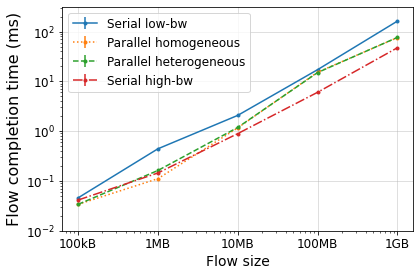

In [8]:
# Figure 9
FLOW_SIZES_LOG10 = [x for x in range(5, 9 + 1)]
Ks = [1, 2, 4, 8, 16]
NETWORKS = ['single', 'homogeneous', 'heterogeneous', 'large']
EXP_IDS = [x + 1 for x in range(5)]

COLORS = {}
# for K in Ks:
#     COLORS[K] = get_next_color()

ax = plt.gca()
index = 0
for network in NETWORKS:
    index += 0.1
#     plt.figure()
#     ax = plt.gca()
    values_x = []
    values_y_by_K_median = {}
    values_y_by_K_99tile = {}
    values_y_by_K_std = {}
    for flow_size_log10 in FLOW_SIZES_LOG10:
        values_x.append(int(pow(10, flow_size_log10)))
        for K in Ks:
#             combined_fct = []
            all_fcts = {}
            for exp_id in EXP_IDS:
                sub_dir = '10e%d.K=%d/exp%d.%s' % (flow_size_log10, K, exp_id, network)
                fct_filename = os.path.join(base_dir, sub_dir, 'fct.ssv')
                d = parse_fct(fct_filename)
                fct_array = np.array(sorted(get_fct_array(d))) * 1e3 # ms
                all_fcts[exp_id] = list(fct_array)
#             combined_fct = sorted(combined_fct)
            stats = get_stats(all_fcts)
            if K not in values_y_by_K_median:
                values_y_by_K_median[K] = []
            if K not in values_y_by_K_99tile:
                values_y_by_K_99tile[K] = []
            if K not in values_y_by_K_std:
                values_y_by_K_std[K] = []
            values_y_by_K_median[K].append(stats['median'])
            values_y_by_K_99tile[K].append(stats['percent99'])
#             print (stats['std'] / stats['median'])
#     plt.figure()
#     ax = plt.gca()
#     for K in Ks:
#         values_y_median = values_y_by_K_median[K]
#         values_y_99tile = values_y_by_K_99tile[K]
#         values_y_std = values_y_by_K_std[K]
#         color = COLORS[K]
#         ax.errorbar(values_x, values_y_median, yerr=values_y_std, label='K=%s (median)' % K, color=color, marker='.')
#         plt.plot(values_x, values_y_median, label='K=%s (median)' % K, color=color, marker='.')
#         plt.plot(values_x, values_y_99tile, label='K=%s (99-tile)' % K, color=color, marker='.', linestyle='--')
#     if network != 'heterogeneous':
#         continue
    if network == 'single' or network == 'large':
        Ks_to_plot = [ 1 ]
    else:
        Ks_to_plot = [ 4 ]
    for K in Ks_to_plot:
        arrays_y_median = values_y_by_K_median[K]
        arrays_y_99tile = values_y_by_K_99tile[K]
        values_y_median_avg = [np.average(v) for v in arrays_y_median]
        values_y_median_std = [np.std(v) for v in arrays_y_median]
        values_y_99tile_avg = [np.average(v) for v in arrays_y_99tile]
        values_y_99tile_std = [np.std(v) for v in arrays_y_99tile]
        color = get_next_color()
    #     plt.plot(values_x, values_y_median, label='%s' % network, color=color, marker='.')
        ax.errorbar(np.array(values_x) * (1), values_y_median_avg, yerr=values_y_median_std, label=get_exp_name(network), color=color, marker='.', linestyle=get_linestyle(MARKER_INDEX[network] - 1))
#         ax.errorbar(np.array(values_x) * (1), values_y_median_avg, yerr=values_y_median_std, label='%s K=%d' % (get_exp_name(network), K), color=color, marker='.', linestyle=get_linestyle(MARKER_INDEX[network] - 1))
    #     ax.errorbar(np.array(values_x) * (1 + 0), values_y_99tile_avg, yerr=values_y_99tile_std, label='%s' % network, color=color, marker='.')
#end
plt.xscale('log')
plt.yscale('log')
plt.ylim(pow(10, -2), pow(10, 2.5))
plt.legend()
plt.xlabel('Flow size', fontsize=14)
plt.ylabel('Flow completion time (ms)', fontsize=16)
ax.set_xticks([int(pow(10, flow_size_log10)) for flow_size_log10 in FLOW_SIZES_LOG10])
ax.set_xticklabels([humanize_size(int(pow(10, flow_size_log10))) for flow_size_log10 in FLOW_SIZES_LOG10])
   
ax.grid(alpha=0.5)
plt.tight_layout()
if save_figures:
    plt.savefig('fct-vs-flow_size.png')